[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Qiuyi-Hong/SHEMS/blob/main/analysisSHEMS_v4.ipynb)

In [1]:
# # Install necessary packages: 
# !pip install pyomo pandas openpyxl matplotlib jupyter

# # Install cbc solver: 
# !sudo apt-get install  coinor-cbc coinor-libcbc-dev 

# # Download necessary files:
# import urllib.request, sys

# urls = [
#     'https://raw.githubusercontent.com/Qiuyi-Hong/SHEMS/refs/heads/main/SHEMS_v3.py',
#     'https://raw.githubusercontent.com/Qiuyi-Hong/SHEMS/refs/heads/main/SHEMS_v3.dat',
#     'https://raw.githubusercontent.com/Qiuyi-Hong/SHEMS/refs/heads/main/Simulation%20Results/simulation_results_concatenated.csv',
#     'https://raw.githubusercontent.com/Qiuyi-Hong/SHEMS/refs/heads/main/agile-half-hour-actual-rates-25-01-2023_26-01-2024.csv',
#     'https://raw.githubusercontent.com/Qiuyi-Hong/SHEMS/refs/heads/main/simulation_results_completed.csv',
#     ]
# file_names = [url.split('/')[-1] for url in urls]

# for i in range(len(urls)):
#     urllib.request.urlretrieve(urls[i], file_names[i])


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from datetime import datetime, timedelta
%matplotlib inline
import pyomo.environ as pyo
from shems import shems_model

# Data Preparation

In [3]:
data = pd.read_csv("simulation_results_2024.csv")
data.head()

,Date,Dry-bulb temperature (°C),Total system energy (kBtu/h),System natural gas (kBtu/h),System electricity (kBtu/h),Total lights energy (kBtu/h),Lights electricity (kBtu/h),Total equip energy (kBtu/h),Equip electricity (kBtu/h),Total CE ex equip (kgCO2/h),...,Total electricity (kBtu/h),Total grid displaced elec. PV (kBtu/h),Total energy (kBtu/h),Transformer Losses (kBtu/h),DHW demand (kW),SH demand (kW),Total heat demand (kW),Ele demand (kW),Agile Import price (p/kWh),Agile Export price (p/kWh)
0,2023-10-01 00:00:00,10.4,4.824,4.688,0.135,0.0,0.0,2.912,2.912,0.3,...,3.048,0.0,7.736,0.0,0.176006,0.662434,0.838439,0.228635,18.48,8.83
1,2023-10-01 00:30:00,10.4,4.824,4.688,0.135,0.0,0.0,2.912,2.912,0.3,...,3.048,0.0,7.736,0.0,0.176006,0.662434,0.838439,0.228635,17.86,8.56
2,2023-10-01 01:00:00,11.5,4.824,4.688,0.135,0.0,0.0,2.912,2.912,0.3,...,3.048,0.0,7.736,0.0,0.176006,0.687814,0.863820,0.228635,16.32,7.90
3,2023-10-01 01:30:00,11.5,4.824,4.688,0.135,0.0,0.0,2.912,2.912,0.3,...,3.048,0.0,7.736,0.0,0.176006,0.687814,0.863820,0.228635,15.17,7.41
4,2023-10-01 02:00:00,11.5,4.824,4.688,0.135,0.0,0.0,2.912,2.912,0.3,...,3.048,0.0,7.736,0.0,0.176006,0.704735,0.880740,0.228635,11.03,5.62


In [4]:
data.set_index('Date', inplace=True)
# Slice the DataFrame from a start date to the end
start_date = '2024-02-25 00:00:00'
end_date = '2024-02-25 23:30:00'
data = data.loc[start_date:end_date]
data.reset_index(inplace=True)
T = data.shape[0]

# Convert the format of the start date for the figure file name
modified_start_date = start_date.replace(':', '_').replace(' ', '_')

In [5]:
# Solar PV generation
eta = 0.157
S = 20
solar_radiation = data["Direct radiation (W/m²)"]/1000
outdoor_temp = data["Dry-bulb temperature (°C)"]

pv = eta * S * solar_radiation *(1 - 0.005 * (outdoor_temp - 25))

In [6]:
# COP calculation
a = - 0.087
b = 6.8 
COP = a * (outdoor_temp + 30 - outdoor_temp) + b 

In [7]:
delta_t = 0.5

demand_ele = data["Ele demand (kW)"]
demand_gas = data["Total heat demand (kW)"]/0.95

demand_SH = data["SH demand (kW)"]
demand_DHW = data["DHW demand (kW)"]
demand_heat = data["Total heat demand (kW)"][:T]

# Electricity price
ele_import_price = data["Agile Import price (p/kWh)"]
ele_export_price = data["Agile Export price (p/kWh)"]

In [8]:
# Accurate Q_TES_init calculation
T_TES_init = 50
T_inlet = 10
V_TES = 0.3

Q_TES_init = (1000*V_TES*4186*(T_TES_init - T_inlet))/3.6e6
print(Q_TES_init)

# Accurate Q_TES_max calculation
T_TES_max = 70
Q_TES_max = (1000*V_TES*4186*(T_TES_max - T_inlet))/3.6e6
print(Q_TES_max)

13.953333333333333
20.93


In [9]:
inputs = {
    "T": T,
    "delta_t": delta_t,
    "d_ele": demand_ele,
    "d_SH": demand_SH,
    "d_DHW": demand_DHW,
    "pi_import": ele_import_price,
    "pi_export": ele_export_price,
    # ASHP
    "T_out": outdoor_temp,
    "COP": COP,
    "q_HP_max": 10,
    "q_HP_min": 0,
    # Comfort params
    ## For SH
    "rho_in": 1.2041,
    "V_in": 3277,
    "c_in": 1000,
    "T_in_LB": 19,
    "T_in_UB": 23,
    "K_SH": 0.0025,
    "T_in_init": 21,
    ## For DHW
    "c_TES": 4186,
    "T_TES_LB": 45,
    "T_TES_UB": 55,
    "K_TES": 0.0025,
    "T_TES_init": T_TES_init,
    # TES params
    "Q_TES_min": 0,
    "Q_TES_max": Q_TES_max,
    "Q_TES_init": Q_TES_init,
    "V_TES": V_TES,
    "rho_TES": 1000,
    "T_inlet": T_inlet,
    "T_TES_max": T_TES_max,
    "p_pv": pv
}

# SHEMS

In [10]:
shems = shems_model(inputs)

In [11]:
from sys import platform

if platform == "linux":
    # linux
    solver = pyo.SolverFactory('cbc', executable='/usr/bin/cbc')
elif platform == "darwin":
    # maxOS
    solver = pyo.SolverFactory('cplex', executable = '/Applications/CPLEX_Studio221/cplex/bin/x86-64_osx/cplex')
    # solver = pyo.SolverFactory('scip', solver_io='nl')
    # solver = pyo.SolverFactory('cbc')
    solver = pyo.SolverFactory('gurobi')

solver.solve(shems)

{'Problem': [{'Name': 'x1', 'Lower bound': 144.73868552561285, 'Upper bound': 144.7521519896658, 'Number of objectives': 1, 'Number of constraints': 1104, 'Number of variables': 624, 'Number of binary variables': 96, 'Number of integer variables': 96, 'Number of continuous variables': 528, 'Number of nonzeros': 2061, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '0.022042036056518555', 'Error rc': 0, 'Time': 0.18329191207885742}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [12]:
obj_value = pyo.value(shems.obj)
print("Objective function value:", obj_value)

Objective function value: 144.7521519896658


## Visualisation

In [13]:
# Values of decision variables
values = pd.DataFrame(data={'T_TES': [pyo.value(shems.T_TES[t]) for t in range(T)],
                            'q_HP': [pyo.value(shems.q_HP[t]) for t in range(T)],                           
                            'p_HP': [pyo.value(shems.p_HP[t]) for t in range(T)],
                            'q_SH': [pyo.value(shems.q_SH[t]) for t in range(T)],
                            'q_DHW': [pyo.value(shems.q_DHW[t]) for t in range(T)],
                            'T_in': [pyo.value(shems.T_in[t]) for t in range(T)],
                            'epsilon_SH': [pyo.value(shems.epsilon_SH[t]) for t in range(T)],
                            'epsilon_TES': [pyo.value(shems.epsilon_TES[t]) for t in range(T)],
                            'Q_TES': [pyo.value(shems.Q_TES[t]) for t in range(T)],
                            'p_import': [pyo.value(shems.p_import[t]) for t in range(T)],
                            'p_export': [pyo.value(shems.p_export[t]) for t in range(T)],
                            'd_SH': [pyo.value(shems.d_SH[t]) for t in range(T)],
                            'd_DHW': [pyo.value(shems.d_DHW[t]) for t in range(T)]})
                      

In [14]:
values.head()

,T_TES,q_HP,p_HP,q_SH,q_DHW,T_in,epsilon_SH,epsilon_TES,Q_TES,p_import,p_export,d_SH,d_DHW
0,49.319589,0.000000,0.000000,0.000000,0.0,20.424548,0.050811,0.123049,13.715983,0.228635,0.0,1.210655,0.351651
1,48.640949,0.000000,0.000000,0.000000,0.0,19.849751,0.049374,0.121352,13.479251,0.228635,0.0,1.210655,0.352112
2,47.960453,0.000000,0.000000,0.000000,0.0,19.268758,0.049422,0.121151,13.241871,0.228635,0.0,1.224191,0.353609
3,47.278871,0.683788,0.163195,0.683788,0.0,19.000000,0.048750,0.119447,13.004113,0.391830,0.0,1.224191,0.356070
4,46.599622,1.270499,0.303222,1.270499,0.0,19.000000,0.048000,0.116999,12.767168,0.531857,0.0,1.222499,0.356890


In [15]:
T_TES = [pyo.value(shems.T_TES[t]) for t in range(T)]
q_HP = [pyo.value(shems.q_HP[t]) for t in range(T)]
p_HP = [pyo.value(shems.p_HP[t]) for t in range(T)]
q_SH = [pyo.value(shems.q_SH[t]) for t in range(T)]
q_DHW = [pyo.value(shems.q_DHW[t]) for t in range(T)]
T_in = [pyo.value(shems.T_in[t]) for t in range(T)]
epsilon_SH = [pyo.value(shems.epsilon_SH[t]) for t in range(T)]
epsilon_TES = [pyo.value(shems.epsilon_TES[t]) for t in range(T)]
Q_TES = [pyo.value(shems.Q_TES[t]) for t in range(T)]
p_import = [pyo.value(shems.p_import[t]) for t in range(T)]
p_export = [pyo.value(shems.p_export[t]) for t in range(T)]

d_ele = [pyo.value(shems.d_ele[t]) for t in range(T)]
d_SH = [pyo.value(shems.d_SH[t]) for t in range(T)]
d_DHW = [pyo.value(shems.d_DHW[t]) for t in range(T)]
p_pv = [pyo.value(shems.p_pv[t]) for t in range(T)]

### Electricity Profile

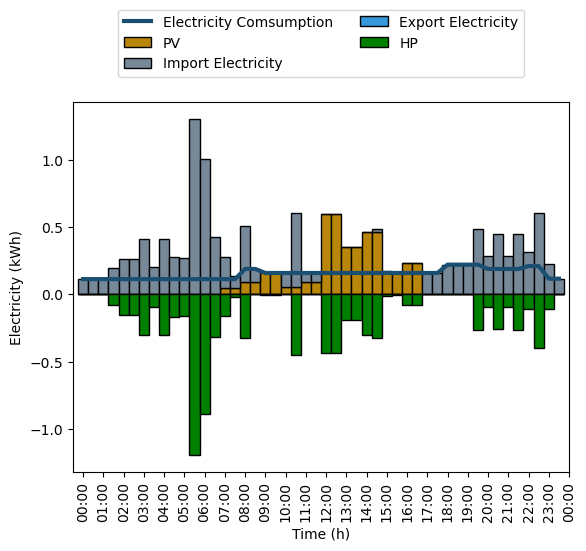

In [16]:
fig, ax1 = plt.subplots()
lineStyle = ["-", "-.", "--", ":"]    
patterns = [ "/" , "\\", "*" , "+" , "-", "o", "O", "x", "*", "|"]

# Generate a range of datetime objects from 00:00 to 23:30 with half-hourly intervals
start_time = datetime(2023, 1, 1)  # Arbitrary date, time is what matters here
end_time = start_time + timedelta(hours=24)
time_range = [start_time + timedelta(minutes=30)*i for i in range(48)]
bar_width = (time_range[1] - time_range[0]).total_seconds() / (24*60*60)  # Convert to fraction of a day

ax1.plot(time_range, np.array(d_ele)*delta_t, label="Electricity Comsumption", color="#1B4F72", linestyle=lineStyle[0], linewidth=3)

ax1.bar(time_range, np.array(p_pv)*delta_t, width=bar_width, label="PV", color="#B8860B", edgecolor="black")

ax1.bar(time_range, np.array(p_import)*delta_t, bottom=np.array(p_pv)*delta_t, width=bar_width, label="Import Electricity", color="#778899", edgecolor="black")

ax1.bar(time_range, np.negative(p_export)*delta_t, width=bar_width, label="Export Electricity", color="#3498DB", edgecolor="black")

ax1.bar(time_range, np.negative(p_HP)*delta_t, bottom=np.negative(p_export)*delta_t, width=bar_width, label="HP", color="#008000", edgecolor="black")

# Formatting the x-axis to display time in HH:MM format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Setting x-axis limits
ax1.set_xlim(start_time - timedelta(minutes=30), end_time)

# Setting x-axis ticks to be every half hour
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 60], interval=1))

plt.xticks(rotation=90)  # Rotate labels to avoid overlap

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Electricity (kWh)")


# Collect handles and labels
handles1, labels1 = ax1.get_legend_handles_labels()

# Create a single legend
ax1.legend(handles1, labels1, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.savefig(f"./figures/shems_electricity_{modified_start_date}.pdf", bbox_inches='tight')
plt.show()

### Heat Consumption

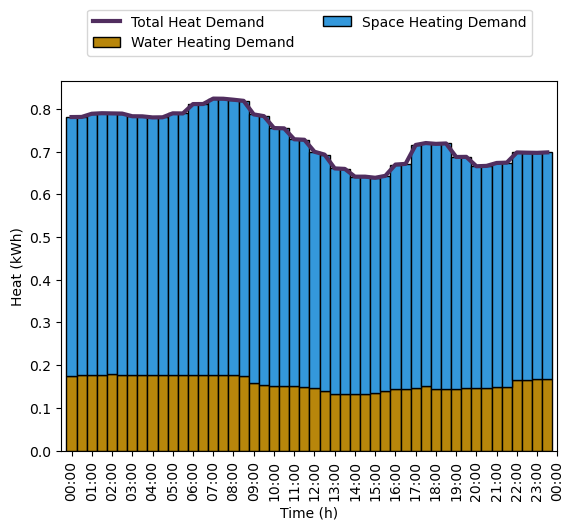

In [17]:
fig, ax1 = plt.subplots()
lineStyle = ["-", "-.", "--", ":"]    
patterns = [ "/" , "\\", "*" , "+" , "-", "o", "O", "x", "*", "|"]

# Generate a range of datetime objects from 00:00 to 23:30 with half-hourly intervals
start_time = datetime(2023, 1, 1)  # Arbitrary date, time is what matters here
end_time = start_time + timedelta(hours=24)
time_range = [start_time + timedelta(minutes=30)*i for i in range(48)]
bar_width = (time_range[1] - time_range[0]).total_seconds() / (24*60*60)  # Convert to fraction of a day

ax1.plot(time_range, np.array(demand_heat)*delta_t, label="Total Heat Demand", color="#512E5F", linestyle=lineStyle[0], linewidth=3)

ax1.bar(time_range, np.array(d_DHW)*delta_t, width=bar_width, label="Water Heating Demand", color="#B8860B", edgecolor="black")

ax1.bar(time_range, np.array(d_SH)*delta_t, bottom= np.array(d_DHW)*delta_t, width=bar_width, label="Space Heating Demand", color="#3498DB", edgecolor="black")

# Formatting the x-axis to display time in HH:MM format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Setting x-axis limits
ax1.set_xlim(start_time - timedelta(minutes=30), end_time)

# Setting x-axis ticks to be every half hour
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 60], interval=1))

plt.xticks(rotation=90)  # Rotate labels to avoid overlap

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Heat (kWh)")

# Collect handles and labels
handles1, labels1 = ax1.get_legend_handles_labels()

# Create a single legend
ax1.legend(handles1, labels1, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.savefig(f"./figures/shems_heat_{modified_start_date}.pdf", bbox_inches='tight')
plt.show()

### HP Operation

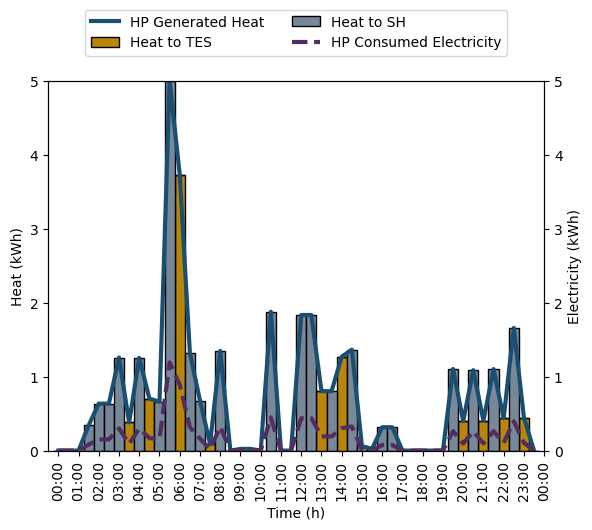

In [18]:
fig, ax1 = plt.subplots()
lineStyle = ["-", "-.", "--", ":"]    
patterns = [ "/" , "\\", "*" , "+" , "-", "o", "O", "x", "*", "|"]

# Generate a range of datetime objects from 00:00 to 23:30 with half-hourly intervals
start_time = datetime(2023, 1, 1)  # Arbitrary date, time is what matters here
end_time = start_time + timedelta(hours=24)
time_range = [start_time + timedelta(minutes=30)*i for i in range(48)]
bar_width = (time_range[1] - time_range[0]).total_seconds() / (24*60*60)  # Convert to fraction of a day

ax1.plot(time_range, np.array(q_HP)*delta_t, label="HP Generated Heat", color="#1B4F72", linestyle=lineStyle[0], linewidth=3)

ax1.bar(time_range, np.array(q_DHW)*delta_t, width=bar_width, label="Heat to TES", color="#B8860B", edgecolor="black")

ax1.bar(time_range, np.array(q_SH)*delta_t, bottom=np.array(q_DHW)*delta_t, width=bar_width, label="Heat to SH", color="#778899", edgecolor="black")

# Formatting the x-axis to display time in HH:MM format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Setting x-axis limits
ax1.set_xlim(start_time - timedelta(minutes=30), end_time)

# Setting x-axis ticks to be every half hour
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 60], interval=1))

plt.xticks(rotation=90)  # Rotate labels to avoid overlap

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Heat (kWh)")

# Set the range of the y-axis for ax1
ax1.set_ylim(0, np.max(q_HP)*delta_t)  # Adjust the limits as needed

# Second y-axis
ax2 = ax1.twinx() 
ax2.plot(time_range, np.array(p_HP)*delta_t, label="HP Consumed Electricity", color="#512E5F", linestyle=lineStyle[2], linewidth=3)  
ax2.set_ylabel("Electricity (kWh)")

# Set the range of the y-axis for ax2
ax2.set_ylim(0, np.max(q_HP)*delta_t)  # Adjust the limits as needed

# Collect handles and labels for both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
all_handles = handles1 + handles2
all_labels = labels1 + labels2

# Create a single legend
ax1.legend(all_handles, all_labels, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)
plt.savefig(f"./figures/shems_HP_{modified_start_date}.pdf", bbox_inches='tight')
plt.show()

### TES Operation

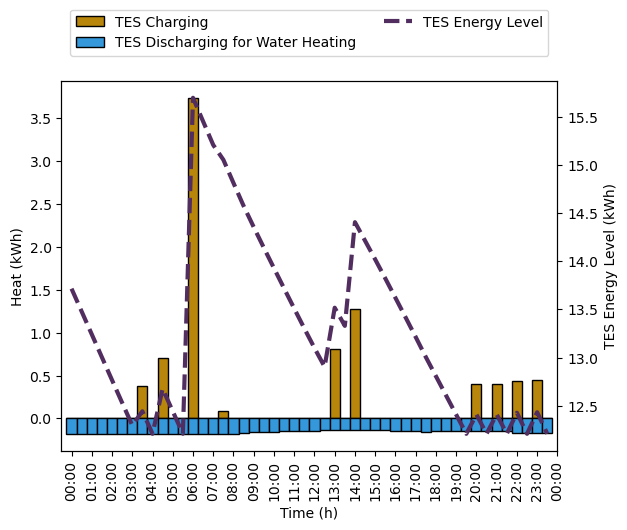

In [19]:
fig, ax1 = plt.subplots()
lineStyle = ["-", "-.", "--", ":"]    
patterns = [ "/" , "\\", "*" , "+" , "-", "o", "O", "x", "*", "|"]

# Generate a range of datetime objects from 00:00 to 23:30 with half-hourly intervals
start_time = datetime(2023, 1, 1)  # Arbitrary date, time is what matters here
end_time = start_time + timedelta(hours=24)
time_range = [start_time + timedelta(minutes=30)*i for i in range(48)]
bar_width = (time_range[1] - time_range[0]).total_seconds() / (24*60*60)  # Convert to fraction of a day

# ax1.plot(time_range, np.array(d_heat), label="Heat Comsumption", color="#1B4F72", linestyle=lineStyle[0], linewidth=3)

ax1.bar(time_range, np.array(q_DHW)*delta_t, width=bar_width, label="TES Charging", color="#B8860B", edgecolor="black")

ax1.bar(time_range, np.negative(d_DHW)*delta_t, width=bar_width, label="TES Discharging for Water Heating", color="#3498DB", edgecolor="black")

# Formatting the x-axis to display time in HH:MM format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Setting x-axis limits
ax1.set_xlim(start_time - timedelta(minutes=30), end_time)

# Setting x-axis ticks to be every half hour
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 60], interval=1))

plt.xticks(rotation=90)  # Rotate labels to avoid overlap

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Heat (kWh)")

# Second y-axis
ax2 = ax1.twinx() 
ax2.plot(time_range, np.array(Q_TES), label="TES Energy Level", color="#512E5F", linestyle=lineStyle[2], linewidth=3)  
ax2.set_ylabel("TES Energy Level (kWh)")
# ax2.legend()

# Collect handles and labels for both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
all_handles = handles1 + handles2
all_labels = labels1 + labels2

# Create a single legend
ax1.legend(all_handles, all_labels, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.savefig(f"./figures/shems_TES_{modified_start_date}.pdf", bbox_inches='tight')
plt.show()

### Temperature Comfort Control

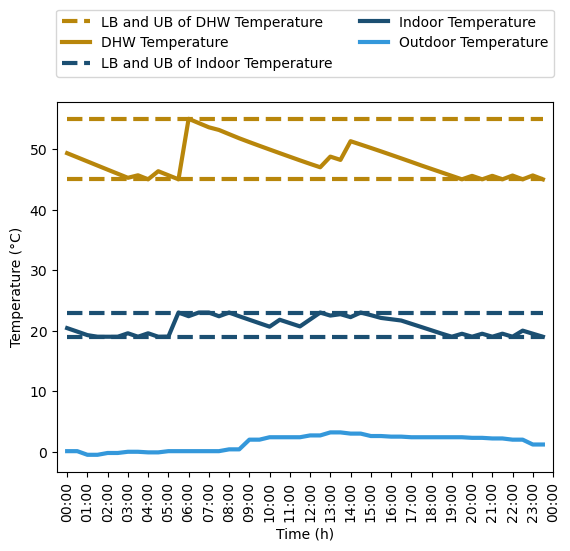

In [20]:
T_TES_LB = shems.T_TES_LB.value
T_TES_UB = shems.T_TES_UB.value

T_in_LB = shems.T_in_LB.value
T_in_UB = shems.T_in_UB.value

T_out = [pyo.value(shems.T_out[t]) for t in range(T)]

fig, ax1 = plt.subplots()
lineStyle = ["-", "-.", "--", ":"]    
patterns = [ "/" , "\\", "*" , "+" , "-", "o", "O", "x", "*", "|"]

# Generate a range of datetime objects from 00:00 to 23:30 with half-hourly intervals
start_time = datetime(2023, 1, 1)  # Arbitrary date, time is what matters here
end_time = start_time + timedelta(hours=24)
time_range = [start_time + timedelta(minutes=30)*i for i in range(48)]
bar_width = (time_range[1] - time_range[0]).total_seconds() / (24*60*60)  # Convert to fraction of a day

ax1.plot(time_range, np.array([T_TES_UB]*T), label="LB and UB of DHW Temperature", color="#B8860B", linestyle=lineStyle[2], linewidth=3)

ax1.plot(time_range, np.array(T_TES), label="DHW Temperature", color="#B8860B", linestyle=lineStyle[0], linewidth=3)

ax1.plot(time_range, np.array([T_TES_LB]*T), color="#B8860B", linestyle=lineStyle[2], linewidth=3)

ax1.plot(time_range, np.array([T_in_UB]*T), label="LB and UB of Indoor Temperature", color="#1B4F72", linestyle=lineStyle[2], linewidth=3)

ax1.plot(time_range, np.array(T_in), label="Indoor Temperature", color="#1B4F72", linestyle=lineStyle[0], linewidth=3)

ax1.plot(time_range, np.array([T_in_LB]*T), color="#1B4F72", linestyle=lineStyle[2], linewidth=3)

ax1.plot(time_range, np.array(T_out), label="Outdoor Temperature", color="#3498DB", linestyle=lineStyle[0], linewidth=3)

# Formatting the x-axis to display time in HH:MM format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Setting x-axis limits
ax1.set_xlim(start_time - timedelta(minutes=30), end_time)

# Setting x-axis ticks to be every half hour
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 60], interval=1))

plt.xticks(rotation=90)  # Rotate labels to avoid overlap

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Temperature (°C)")


# Collect handles and labels
handles1, labels1 = ax1.get_legend_handles_labels()

# Create a single legend
ax1.legend(handles1, labels1, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.savefig(f"./figures/shems_temperature_{modified_start_date}.pdf", bbox_inches='tight')
plt.show()

### Import & Export Electricity Prices

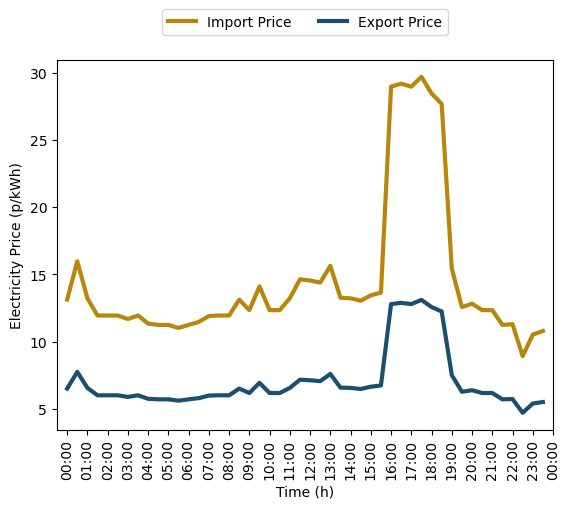

In [21]:
pi_import = [pyo.value(shems.pi_import[t]) for t in range(T)]
pi_export = [pyo.value(shems.pi_export[t]) for t in range(T)]

fig, ax1 = plt.subplots()
lineStyle = ["-", "-.", "--", ":"]    
patterns = [ "/" , "\\", "*" , "+" , "-", "o", "O", "x", "*", "|"]

# Generate a range of datetime objects from 00:00 to 23:30 with half-hourly intervals
start_time = datetime(2023, 1, 1)  # Arbitrary date, time is what matters here
end_time = start_time + timedelta(hours=24)
time_range = [start_time + timedelta(minutes=30)*i for i in range(48)]
bar_width = (time_range[1] - time_range[0]).total_seconds() / (24*60*60)  # Convert to fraction of a day

ax1.plot(time_range, np.array(pi_import), label="Import Price", color="#B8860B", linestyle=lineStyle[0], linewidth=3)

ax1.plot(time_range, np.array(pi_export), label="Export Price", color="#1B4F72", linestyle=lineStyle[0], linewidth=3)

# Formatting the x-axis to display time in HH:MM format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Setting x-axis limits
ax1.set_xlim(start_time - timedelta(minutes=30), end_time)

# Setting x-axis ticks to be every half hour
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 60], interval=1))

plt.xticks(rotation=90)  # Rotate labels to avoid overlap

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Electricity Price (p/kWh)")


# Collect handles and labels
handles1, labels1 = ax1.get_legend_handles_labels()

# Create a single legend
ax1.legend(handles1, labels1, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.savefig(f"./figures/electricity_prices_{modified_start_date}.pdf", bbox_inches='tight')
plt.show()

# Gas Boiler Comparison

In [22]:
# Jan_Mar_gas_cap = 2137/12000 # 0.17808333
# Apr_Jun_gas_cap = 1610/12000 # 0.13416667
# Jul_Sep_gas_cap = 998/12000 # 0.08316667
Oct_Dec_gas_cap = 881.94/12000 # 0.073495
Jan_Mar_gas_cap = 941.82/12000 # 0.078485
Apr_Jun_gas_cap = 798.66/12000 # 0.066555
Jul_Sep_gas_cap = 734.33/12000 # 0.061194

# avg_gas_cap = (Jan_Mar_gas_cap + Apr_Jun_gas_cap + Jul_Sep_gas_cap + Oct_Dec_gas_cap)/4
# avg_gas_cap # = 0.11814583333333334

# annual_avg_gas_price = 1304/13600 # 0.09588235

# rate = annual_avg_gas_price/avg_gas_cap # 0.8100000000000001

rate = 0.8

Oct_Dec_gas_avg = Oct_Dec_gas_cap * rate * 100 # 7.3495
Jan_Mar_gas_avg = Jan_Mar_gas_cap * rate * 100 # 7.8485
Apr_Jun_gas_avg = Apr_Jun_gas_cap * rate * 100 # 6.6555
Jul_Sep_gas_avg = Jul_Sep_gas_cap * rate * 100 # 6.1194

In [23]:
# Assuming 'data' is your DataFrame and 'Date' is already in datetime format
data['Date'] = pd.to_datetime(data['Date'])

costs_total_gas = 0

for index, row in data.iterrows():
    t = row['Date']
    if t >= pd.to_datetime('2023-10-01 00:00:00') and t <= pd.to_datetime('2023-12-31 23:30:00'):
        gas_price = Oct_Dec_gas_avg     
        if demand_ele[index] - pv[index] >= 0:
            costs_total_gas += demand_gas[index] * delta_t * gas_price + ele_import_price[index] * (demand_ele[index] - pv[index]) * delta_t
        else:
            costs_total_gas += demand_gas[index] * delta_t * gas_price - ele_export_price[index] * (pv[index] - demand_ele[index]) * delta_t
    elif t >= pd.to_datetime('2024-01-01 00:00:00') and t <= pd.to_datetime('2024-03-31 23:30:00'):
        gas_price = Jan_Mar_gas_avg
        if demand_ele[index] - pv[index] >= 0:
            costs_total_gas += demand_gas[index] * delta_t * gas_price + ele_import_price[index] * (demand_ele[index] - pv[index]) * delta_t
        else:
            costs_total_gas += demand_gas[index] * delta_t * gas_price - ele_export_price[index] * (pv[index] - demand_ele[index]) * delta_t
    elif t >= pd.to_datetime('2024-04-01 00:00:00') and t <= pd.to_datetime('2024-06-30 23:30:00'):
        gas_price = Apr_Jun_gas_avg
        if demand_ele[index] - pv[index] >= 0:
            costs_total_gas += demand_gas[index] * delta_t * gas_price + ele_import_price[index] * (demand_ele[index] - pv[index]) * delta_t
        else:
            costs_total_gas += demand_gas[index] * delta_t * gas_price - ele_export_price[index] * (pv[index] - demand_ele[index]) * delta_t
    elif t >= pd.to_datetime('2023-07-01 00:00:00') and t <= pd.to_datetime('2023-09-30 23:30:00'):
        gas_price = Jul_Sep_gas_avg
        if demand_ele[index] - pv[index] >= 0:
            costs_total_gas += demand_gas[index] * delta_t * gas_price + ele_import_price[index] * (demand_ele[index] - pv[index]) * delta_t
        else:
            costs_total_gas += demand_gas[index] * delta_t * gas_price - ele_export_price[index] * (pv[index] - demand_ele[index]) * delta_t

In [24]:
costs_total_gas

np.float64(289.7634495454975)

In [25]:
# Create a file and write the results to it
with open('cost_results_daily_2024.txt', 'a') as file:
    file.write(f"From {start_date} to {end_date}: Cost HP: {pyo.value(shems.obj)}, Cost Gas Boiler: {costs_total_gas}\n")

In [26]:
# # This cell needs to be run only once to create the initial CSV file!!!
# # Create initial DataFrame
# data = {
#     'From': [],
#     'To': [],
#     'Cost_HP': [],
#     'Cost_Gas_Boiler': []
# }
# df = pd.DataFrame(data)

# # Write to CSV file
# df.to_csv('cost_results_daily_2024.csv', index=False)

In [27]:
# Read the existing CSV file
existing_df = pd.read_csv('cost_results_daily_2024.csv')

# Create new data to append
new_data = {
    'From': [start_date],
    'To': [end_date],
    'Cost_HP': [pyo.value(shems.obj)],
    'Cost_Gas_Boiler': [costs_total_gas]
}
new_df = pd.DataFrame(new_data)

# Append new data to the existing DataFrame
updated_df = pd.concat([existing_df, new_df], ignore_index=True)

In [28]:
# Write the updated DataFrame back to the CSV file
updated_df.to_csv('cost_results_daily_2024.csv', index=False)